In [ ]:
# ruff: noqa: N802, N803, N806, N815, N816
import os

import numpy as np
import matplotlib.pyplot as plt

import archimedes as arc
from archimedes.experimental.signal import tf2ss

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

# Part 3: Custom system ID

So far in this tutorial series we have been using the typical least-squres formulation of the system identification problem:

$$
\min_p \sum_{k=1}^N ||y_k - \hat{y}_k(p)||^2.
$$

This works well on simple benchmark problems like the Duffing oscillator, or on "white-box" models where the physics are known precisely and the identification problem is a matter of calibrating a few parameters.

In practice, however, simply optimizing a predictive model against time-series data may not be sufficient; you may want more flexibility in how you formulate the problem.

## Multiple data sources

As an illustrative case, let's consider a situtation where we have both transient time-series data and steady-state response at a number of operating points.
For a stable system, a straightforward way to do this is to collect data with a "ladder" input:

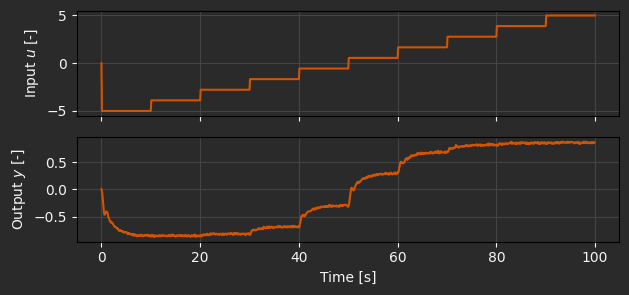

In [2]:
raw_data = np.loadtxt("data/part3_ladder.csv", skiprows=1, delimiter="\t")

ladder_data = arc.sysid.Timeseries(
    ts=raw_data[:, 0],
    us=raw_data[:, 1].reshape(1, -1),
    ys=raw_data[:, 2].reshape(1, -1),
)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(ladder_data.ts, ladder_data.us[0], label="Input ($u$)")
ax[0].set_ylabel("Input $u$ [-]")
ax[0].grid()
ax[1].plot(ladder_data.ts, ladder_data.ys[0], label="Output ($y$)")
ax[1].set_ylabel("Output $y$ [-]")
ax[1].grid()
ax[-1].set_xlabel("Time [s]")
plt.show()

We could treat this data either as another time series or as a set of known steady-state "operating points" $(u^{(i)}, y^{(i)})$, $i = 1, 2, 3, ...$.
For the sake of understanding how to incorporate different information into the optimization problem, let's reduce the time series to the set of operating points by averaging the final second end of each "hold" interval.

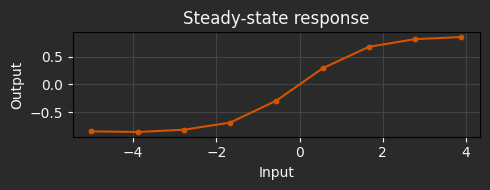

In [3]:
# Estimate steady-state response to each input
# using the final second of each 10s hold interval
interval = 10.0  # Hold interval for ladder
u_ss = []
y_ss = []
for i in range(int(ladder_data.ts[-1] // interval)):
    tf_int = interval * (i + 1)
    idx = (ladder_data.ts > tf_int - 1.0) * (ladder_data.ts < tf_int)
    u_ss.append(np.mean(ladder_data.us[0, idx]))
    y_ss.append(np.mean(ladder_data.ys[0, idx]))


fig, ax = plt.subplots(1, 1, figsize=(5, 2), sharex=True)
ax.plot(u_ss, y_ss)
ax.scatter(u_ss, y_ss, s=10)
ax.set_xlabel("Input")
ax.set_ylabel("Output")
ax.set_title("Steady-state response")
ax.grid()
plt.tight_layout()
plt.show()

In addition to these steady-state operating points, we also have transient data from a step response and a "chirp" frequency sweep:

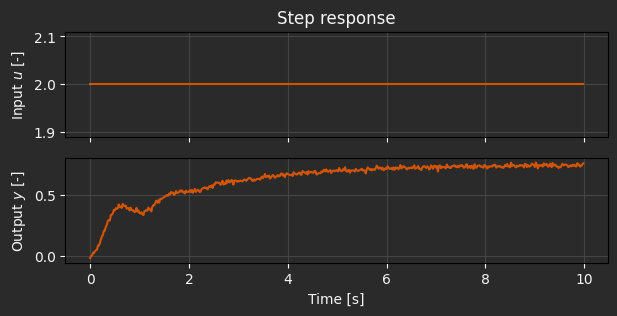

In [4]:
raw_data = np.loadtxt("data/part3_step.csv", skiprows=1, delimiter="\t")

step_data = arc.sysid.Timeseries(
    ts=raw_data[:, 0],
    us=raw_data[:, 1].reshape(1, -1),
    ys=raw_data[:, 2].reshape(1, -1),
)
dt = step_data.ts[1] - step_data.ts[0]

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(step_data.ts, step_data.us[0], label="Input ($u$)")
ax[0].set_ylabel("Input $u$ [-]")
ax[0].grid()
ax[1].plot(step_data.ts, step_data.ys[0], label="Output ($y$)")
ax[1].set_ylabel("Output $y$ [-]")
ax[1].grid()

ax[0].set_title("Step response")
ax[-1].set_xlabel("Time [s]")
plt.show()

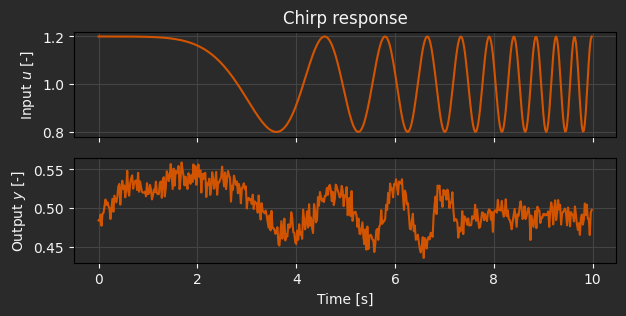

In [5]:
raw_data = np.loadtxt("data/part3_chirp.csv", skiprows=1, delimiter="\t")

chirp_data = arc.sysid.Timeseries(
    ts=raw_data[:, 0],
    us=raw_data[:, 1].reshape(1, -1),
    ys=raw_data[:, 2].reshape(1, -1),
)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(chirp_data.ts, chirp_data.us[0], label="Input ($u$)")
ax[0].set_ylabel("Input $u$ [-]")
ax[0].grid()
ax[1].plot(chirp_data.ts, chirp_data.ys[0], label="Output ($y$)")
ax[1].set_ylabel("Output $y$ [-]")
ax[1].grid()

ax[0].set_title("Chirp response")
ax[-1].set_xlabel("Time [s]")
plt.show()

In total, we have three different data sources:

1. Steady-state operating points $(u^{(i)}, y^{(i)})$
2. Transient step response
3. Transient chirp response

## Fitting a single time series

To start with, let's suppose we want to use one of these datasets to fit the model and the other two as validation data.
Then we can simply use the same identification workflow as previous examples.

Once again, we're using synthetic data to keep the focus on the basic algorithms and cases where we have a known "true" solution.
In this case the data was generated from a "Hammerstein-Wiener" system with a tanh input nonlinearity, a third-order linear system, and a cubic output nonlinearity.

<!-- PLACHOLDER: Hammerstein-Wiener system -->
```{image} _static/placeholder.png
:class: only-light
```

```{image} _static/placeholder.png
:class: only-dark
```

We could implement this as a set of nested PyTree classes, but for the sake of simplicity we'll use a simple function-based implementation of the model:

In [6]:
def ode(t, x, u, params):
    x = np.atleast_1d(x)
    u = np.atleast_1d(u)

    num = params["num"]  # Transfer function numerator coefficients
    den = params["den"]  # Transfer function denominator coefficients
    k = params["k"]  # Saturation for tanh nonlinearity

    A, B, C, D = tf2ss(num, den)  # Convert to state-space representation

    # Static input nonlinearity
    u_nl = k * np.tanh(u / k)

    # Linear state-space dynamics
    x_t = A @ x + B @ u_nl
    return x_t


def obs(t, x, u, params):
    x = np.atleast_1d(x)
    u = np.atleast_1d(u)

    num = params["num"]  # Transfer function numerator coefficients
    den = params["den"]  # Transfer function denominator coefficients
    b = params["b"]  # Saturation for tanh nonlinearity

    A, B, C, D = tf2ss(num, den)  # Convert to state-space representation
    y = C @ x + D @ u  # Linear output equation

    # Static output nonlinearity
    return y + b * y**3

In [7]:
# Fit a single time series
params_guess = {
    "num": np.array([10.0, 10.0]),
    "den": np.array([1.0, 5.0, 60.0, 30.0]),
    "k": 1.0,  # Saturation for tanh nonlinearity
    "b": 0.01,  # Coefficient for cubic nonlinearity
}

nu = 1
ny = 1
nx = len(params_guess["den"]) - 1  # Number of states

noise_var = 0.5 * np.var(np.diff(chirp_data.ys[0]))
R = noise_var * np.eye(ny)  # Measurement noise covariance
Q = 1e-4 * noise_var * np.eye(nx)  # Process noise covariance

# Set up PEM problem
dyn = arc.discretize(ode, dt, method="rk4")
ekf = arc.observers.ExtendedKalmanFilter(dyn, obs, Q, R)

x0_chirp = np.array([0.0, 0.0, 0.05])

result = arc.sysid.pem(
    ekf,
    chirp_data,
    params_guess,
    x0=x0_chirp,
    method="lm",
)

params_opt = result.x

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         3.1199e-02                                   3.08e-02  
    1           4         2.7462e-02       3.74e-03       2.58e-01     3.22e-03  
    2           6         2.7170e-02       2.92e-04       6.93e-02     1.56e-03  
    3           7         2.7057e-02       1.13e-04       9.76e-02     2.68e-03  
    4           8         2.6979e-02       7.76e-05       1.42e-01     5.99e-03  
    5           9         2.6918e-02       6.10e-05       1.87e-01     8.77e-03  
    6           10        2.6811e-02       1.08e-04       2.21e-01     7.45e-03  
    7           11        2.6737e-02       7.42e-05       2.50e-01     5.36e-03  
    8           12        2.6696e-02       4.08e-05       2.86e-01     3.93e-03  
    9           13        2.6672e-02       2.43e-05       3.33e-01     2.94e-03  
    10          14        2.6656e-02       1.55e-05       3.93e-01     2.22e-03  
    11          

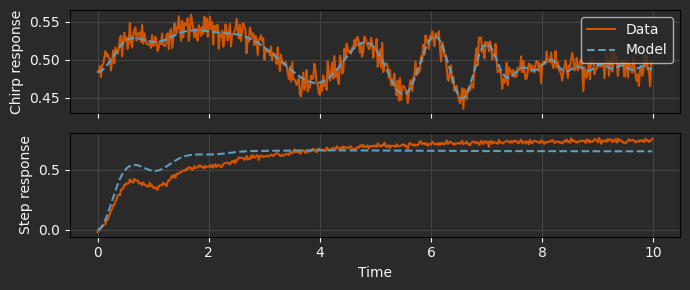

In [8]:
# Evaluate the fit
def simulate(ts, us, x0, params):
    """Simulate the Hammerstein-Wiener system."""

    vmap_obs = arc.vmap(obs, in_axes=(0, 1, 1, None))

    def ode_rhs(t, x, params):
        u = np.interp(t, ts, us[0]).reshape((1,))
        return ode(t, x, u, params)

    xs_true = arc.odeint(
        ode_rhs,
        t_span=(ts[0], ts[-1]),
        x0=x0,
        args=(params,),
        t_eval=ts,
        rtol=1e-8,
        atol=1e-10,
    )

    ys = vmap_obs(ts, xs_true, us, params).T

    return arc.sysid.Timeseries(
        ts=ts,
        us=us,
        ys=ys,
    )


step_pred = simulate(step_data.ts, step_data.us, np.zeros(nx), params_opt)

chirp_pred = simulate(chirp_data.ts, chirp_data.us, x0_chirp, params_opt)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(chirp_data.ts, chirp_data.ys[0], label="Data")
ax[0].plot(chirp_pred.ts, chirp_pred.ys[0], label="Model", linestyle="--")
ax[0].set_ylabel("Chirp response")
ax[0].legend()
ax[0].grid()
ax[1].plot(step_data.ts, step_data.ys[0], label="Data")
ax[1].plot(step_pred.ts, step_pred.ys[0], label="Model", linestyle="--")
ax[1].set_ylabel("Step response")
ax[1].grid()
ax[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

The identified model describes the training data (chirp response) well, but misses the mark on the test data (step response).

To evaluate how well it captures the steady-state behavior, we can loop through the operating points and use an [`implicit`](#archimedes.implicit) function to find the corresponding stationary state of the model:

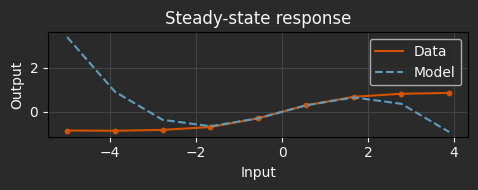

In [9]:
def operating_points(us, params):
    # Residual function for the dynamics (implicit)
    # Returns the right-hand side of the ODE as a function of state and inputs
    def dyn_res(x, u):
        return ode(0, x, u, params)

    # Create an implicit function to calculate the steady state
    # F(x_guess, u) -> x_ss
    find_op = arc.implicit(dyn_res)

    xs = []
    ys = []
    for u in us:
        xs.append(find_op(np.zeros(nx), u))
        ys.append(obs(0, xs[-1], u, params))

    return np.array(ys)


y_ss_pred = operating_points(u_ss, params_opt)

fig, ax = plt.subplots(1, 1, figsize=(5, 2), sharex=True)
ax.plot(u_ss, y_ss, label="Data")
ax.scatter(u_ss, y_ss, s=10)
ax.plot(u_ss, y_ss_pred, label="Model", linestyle="--")
ax.legend()
ax.set_xlabel("Input")
ax.set_ylabel("Output")
ax.set_title("Steady-state response")
ax.grid()
plt.tight_layout()
plt.show()

The chirp response varies the input around a nominal value of 1.0, so it's not especially surprising that the model didn't accurately predict responses to inputs that are far from that nominal value.

In other words, what this suggests is that we need to incorporate more information into the optimization problem.

## Constraining steady-state behavior

We _could_ make use of the "ladder" response data by treating it as another time series.
This is straightforward and might work in some cases, but does not guarantee that the model will actually have the desired stationary states.

Alternatively, we could reformulate the optimization problem to explicitly enforce that the system will have the observed steady-state behavior.
One way to do this is to expand the vector of decision variables to include the unknown equilibrium states for each operating point, and then add constraints that each of these states is in equilibrium.

Mathematically, the new optimization problem looks like this:

\begin{gather}
\min_{(p, x_\mathrm{ss}^{(i)})} \sum_{k=1}^N ||y_k - \hat{y}_k(p)||^2 + \sum_{i=1}^{M} ||y_\mathrm{ss}^{(i)} - \hat{y}_\mathrm{ss}^{(i)}(p)||^2, \\
0 = f(x_\mathrm{ss}^{(i)}, u_\mathrm{ss}^{(i)}, p), \qquad i = 1, 2, \dots, M \\
\hat{y}_\mathrm{ss}^{(i)} = h(x_\mathrm{ss}^{(i)}, u_\mathrm{ss}^{(i)}, p), \qquad i = 1, 2, \dots, M.
\end{gather}

Let's unpack this.
We now have a time series of length $N$ that we're trying to match using the standard prediction error method (the first least-squares term).
We have added in a set of $M$ steady-state operating points with unknown states: $\{ x_\mathrm{ss}^{(i)} \}_{i=1}^M$.
For each of those operating points we now include a _constraint_ that the system has zero time derivative when the corresponding input is applied:

$$
0 = f(x_\mathrm{ss}^{(i)}, u_\mathrm{ss}^{(i)}, p).
$$

Finally, we add a second least-squares objective term that penalizes deviations from the measured steady-state output.

What we have done is added in new optimization variables $x_\mathrm{ss}^{(i)}$ for each operating point that _must_ be in steady state when the corresponding input $u_\mathrm{ss}^{(i)}$ is applied.
The output $y_\mathrm{ss}^{(i)}$ is not explicitly constrained, but the additional least-squares term tries to drive it to match the data.

Note that since we have added nonlinear constraints, now we cannot use a typical least-squares solver.
Instead we will use the IPOPT nonlinear programming solver that can handle general constraints.

### Implementation

It is actually harder to write the math for this problem than it is to implement it, but we will need one new bit of functionality we haven't used: the [`PEMObjective`](#archimedes.sysid.PEMObjective) class.

When we call the high-level system identification interface [`pem`](#archimedes.sysid.pem), the code essentially does two things:

1. Creates a least-squares objective function using the PEM formulation and the provided Kalman filter
2. Passes this objective function to a standard general-purpose optimizer like Levenberg-Marquardt.

The objective function is encapsulated in the lower-level `PEMObjective` class.
This is a callable object with signature `J = obj(params)`, where `J` is the objective function value for the given parameters.
It is created to match a _single_ time series and for a particular Kalman filter.

The `PEMObjective` object also has a `residuals` method that will return, naturally, a flat vector of the Kalman filter residuals for the entire time series.
So for example, if you wanted to combine multiple time series experiments, you could create a separate `PEMObjective` for each, concatenate the residuals, and then pass the multi-experiment objective function to [`least_squares`](#archimedes.optimize.least_squares).

In our case we will use the `PEMObjective` for the time series part of the objective, and manually construct the equilibrium point constraints:

In [10]:
# Decision variables for the custom optimization problem
# The parameters are augmented with steady-state operating points
x_ss = np.zeros((len(y_ss), nx))
dvs = params_guess, x_ss

# Construct the standard system identification objective
# for the chirp response data specifically
P0 = np.eye(nx) * 1e-4  # Initial covariance estimate
chirp_obj = arc.sysid.PEMObjective(
    ekf,
    chirp_data,
    P0=P0,
    x0=x0_chirp,
)


# Combined objective function
def obj(dvs):
    params, x_ss = dvs

    # 1. chirp response objective
    chirp_loss = chirp_obj(params)

    # 2. steady-state response objective
    ss_loss = 0.0
    for i in range(len(x_ss)):
        u0, x0, y0 = u_ss[i], x_ss[i], y_ss[i]
        y0_pred = obs(0, x0, u0, params).squeeze()
        ss_loss += np.sum((y0_pred - y0) ** 2)

    return chirp_loss + ss_loss


# Steady-state constraints for each operating point
# This will construct a vector that must be zero in equilibrium
def constr(dvs):
    params, x_ss = dvs
    x_t = []
    for i in range(len(x_ss)):
        u0, x0 = u_ss[i], x_ss[i]
        x_t.append(ode(0, x0, u0, params))
    return np.hstack(x_t)


# Call IPOPT to solve the optimization problem
# This may take a few minutes due to the complexity of the Hessian calculation
result = arc.optimize.minimize(obj, dvs, constr=constr)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       90
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      225

Total number of variables............................:       35
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       27
Total number of inequality c

In [11]:
params_opt, x0_opt = result.x
params_opt

{'b': array(0.17748123),
 'den': array([ 1.6479384 ,  4.54535236, 59.83214888, 28.2212433 ]),
 'k': array(1.42898101),
 'num': array([ 7.46488981, 15.32889611])}

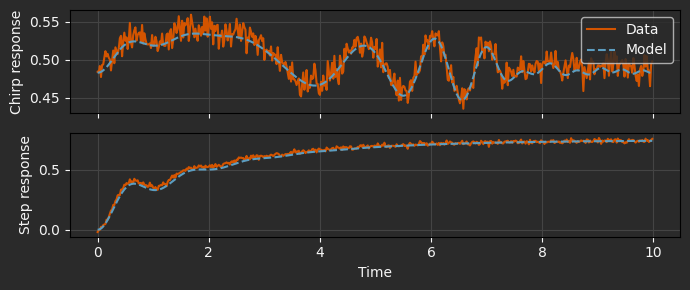

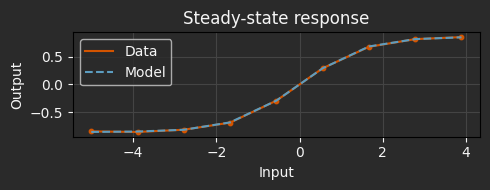

In [12]:
# Evaluate the optimized model

step_pred = simulate(step_data.ts, step_data.us, np.zeros(nx), params_opt)

chirp_pred = simulate(chirp_data.ts, chirp_data.us, x0_chirp, params_opt)

y_ss_pred = operating_points(u_ss, params_opt)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(chirp_data.ts, chirp_data.ys[0], label="Data")
ax[0].plot(chirp_pred.ts, chirp_pred.ys[0], label="Model", linestyle="--")
ax[0].set_ylabel("Chirp response")
ax[0].legend()
ax[0].grid()
ax[1].plot(step_data.ts, step_data.ys[0], label="Data")
ax[1].plot(step_pred.ts, step_pred.ys[0], label="Model", linestyle="--")
ax[1].set_ylabel("Step response")
ax[1].grid()
ax[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 2), sharex=True)
ax.plot(u_ss, y_ss, label="Data")
ax.scatter(u_ss, y_ss, s=10)
ax.plot(u_ss, y_ss_pred, label="Model", linestyle="--")
ax.legend()
ax.set_xlabel("Input")
ax.set_ylabel("Output")
ax.set_title("Steady-state response")
ax.grid()
plt.tight_layout()
plt.show()

Much better!  We can still match the transient training data (chirp response), but now by requiring the model to also match the steady-state data we can also match the test data (step response).

While this particular formulation of the system ID problem may or may not be appropriate for your particular application, the key points are:

1. Directly using the [`PEMObjective`](#archimedes.sysid.PEMObjective) interface for custom optimizations
2. Switching to a general nonlinear programming solver to incorporate hard constraints
3. Being careful about testing your model with data from different regimes to ensure generalization

As with all the examples in this tutorial, this is oversimplified compared to many real-world system ID applications.
In reality, we have not done enough validation to be confident in this model, unless we were confident in the Hammerstein-Wiener structure and the tested range of input values.
We have also dodged the central question of how to arrive at the model structure in the first place.

In [the final part](sysid04.md) of this series we will examine some of these practical considerations more closely and offer some general advice on how to approach nonlinear system identification in the wild.